<a href="https://colab.research.google.com/github/sanxlop/stocks/blob/master/stocks_talib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import talib

%matplotlib inline
plt.style.use('dark_background')

In [0]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# # Get data from yfinance
# def get_historical_yfinance(tickers):
#     tickers = yf.Tickers(" ".join(tickers.keys()))
#     return tickers.history(period="6mo", interval="1d", start=None, end=None, actions=True, rounding=True)

# # Add extra info
# def set_change_label(x):
#     if x > 0:
#         return 1
#     else:
#         return 0

def add_price_transforms(df):
    for ticker in tickers_desc.keys():
        df[ticker,'CHANGE'] = df[ticker,'Close'].diff()
        df[ticker,'CHANGE_PERCENT'] = df[ticker,'Close'].div(df[ticker,'Close'].shift(1))*100-100
        #df[ticker,'CHANGE_LABEL'] = df[ticker,'CHANGE'].apply(set_change_label)
        df[ticker,'AVGPRICE'] = talib.AVGPRICE(df[ticker,'Open'], df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Average Price
        df[ticker,'MEDPRICE'] = talib.MEDPRICE(df[ticker,'High'], df[ticker,'Low']) # Median Price
        df[ticker,'TYPPRICE'] = talib.TYPPRICE(df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Typical Price
        df[ticker,'WCLPRICE'] = talib.WCLPRICE(df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Weighted Close Price
    return df

def add_overlap_functions(df):
    for ticker in tickers_desc.keys():
        df[ticker,'DEMA'] = talib.DEMA(df[ticker,'Close'], timeperiod=30) # Double Exponential Moving Average
        df[ticker,'EMA'] = talib.EMA(df[ticker,'Close'], timeperiod=30) # Exponential Moving Average
        df[ticker,'HT_TRENDLINE'] = talib.HT_TRENDLINE(df[ticker,'Close']) # Hilbert Transform - Instantaneous Trendline
        df[ticker,'KAMA'] = talib.KAMA(df[ticker,'Close'], timeperiod=30) # Kaufman Adaptive Moving Average
        df[ticker,'MA'] = talib.MA(df[ticker,'Close'], timeperiod=30, matype=0) # Moving average
        df[ticker,'MAMA_mama'], df[ticker,'MAMA_fama'] = talib.MAMA(df[ticker,'Close'], fastlimit=0.5, slowlimit=0.05) # MESA Adaptive Moving Average
        #df[ticker,'MAVP'] = talib.MAVP(df[ticker,'Close'], periods, minperiod=2, maxperiod=30, matype=0) # Moving average with variable period
        df[ticker,'MIDPOINT'] = talib.MIDPOINT(df[ticker,'Close'], timeperiod=14) # MidPoint over period
        df[ticker,'MIDPRICE'] = talib.MIDPRICE(df[ticker,'High'], df[ticker,'Low'], timeperiod=14) # Midpoint Price over period
        df[ticker,'SAR'] = talib.SAR(df[ticker,'High'], df[ticker,'Low'], acceleration=0.02, maximum=0.2) # Parabolic SAR
        df[ticker,'SAREXT'] = talib.SAREXT(df[ticker,'High'], df[ticker,'Low'], startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0) # Parabolic SAR - Extended
        df[ticker,'SMA'] = talib.SMA(df[ticker,'Close'], timeperiod=30) # Simple Moving Average
        df[ticker,'T3'] = talib.T3(df[ticker,'Close'], timeperiod=5, vfactor=0.7) # Triple Exponential Moving Average (T3)
        df[ticker,'TEMA'] = talib.TEMA(df[ticker,'Close'], timeperiod=30) # Triple Exponential Moving Average
        df[ticker,'TRIMA'] = talib.TRIMA(df[ticker,'Close'], timeperiod=30) # Triangular Moving Average
        df[ticker,'WMA'] = talib.WMA(df[ticker,'Close'], timeperiod=30) # Weighted Moving Average
    return df

def add_indicators_functions(df, timeperiod=14):
    RSI_LOW_LIMIT = 30
    RSI_UP_LIMIT = 70
    BBP_LOW_LIMIT = 0
    BBP_UP_LIMIT = 1
    BLOW_SHIGH_LOW = 2
    BLOW_SHIGH_UP = 2

    for ticker in tickers_desc.keys():
        df[ticker,'BB_up'], df[ticker,'BB_mid'], df[ticker,'BB_low'] = talib.BBANDS(df[ticker,'Close'].values, timeperiod=timeperiod, nbdevup=2, nbdevdn=2, matype=0) # MA_Type.SMA
        df[ticker,'BBP'] = (df[ticker,'Close'] - df[ticker,'BB_low']) / (df[ticker,'BB_up'] - df[ticker,'BB_low'])
        df[ticker,'RSI'] = talib.RSI(df[ticker,'Close'], timeperiod=timeperiod)
        
        df[ticker,'HOLDINGS'] = 0
        df.loc[((df[ticker,'RSI'] < RSI_LOW_LIMIT) & (df[ticker,'BBP'] < BBP_LOW_LIMIT)), (ticker,'HOLDINGS')] = df[ticker,'RSI']/100 # + price['BBP'])/2 # + Buy Green
        df.loc[((df[ticker,'RSI'] > RSI_UP_LIMIT) & (df[ticker,'BBP'] > BBP_UP_LIMIT)), (ticker,'HOLDINGS')] = -(df[ticker,'RSI']/100) # + price['BBP'])/2 # - Sell Red

        df[ticker,'BLOW_SHIGH'] = 0
        df.loc[(df[ticker,'Close'] < calc_num_low(df[ticker,'Close'], BLOW_SHIGH_LOW)), (ticker,'BLOW_SHIGH')] = calc_percent_low(df[ticker,'Close']) # + Buy Blue
        df.loc[(df[ticker,'Close'] > calc_num_high(df[ticker,'Close'], BLOW_SHIGH_UP)), (ticker,'BLOW_SHIGH')] = -calc_percent_high(df[ticker,'Close']) # - Sell Purple
    return df

def calc_num_low(df_column, percent_thr):
    low_percent = df_column.min() * 100 / df_column.max()
    admit_percent = low_percent + percent_thr
    low_number = df_column.max() * admit_percent / 100
    return low_number

def calc_num_high(df_column, percent_thr):
    high_percent = 100
    admit_percent = high_percent - percent_thr
    high_number = df_column.max() * admit_percent / 100
    return high_number

def calc_percent_low(df_column):
    return df_column.min() / df_column

def calc_percent_high(df_column):
    return df_column / df_column.max()

def plot_result(df, ticker):
    fig, (ax0, ax1, ax3, ax2) = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
    plt.suptitle(ticker)
    ax0.plot(df.index, df[ticker,'Close'], label='Close')
    ax0.set_xlabel('Date')
    ax0.set_ylabel('Close')
    ax0.grid()
    for day, holding in df[ticker].iterrows():
        order = holding['HOLDINGS']
        order2 = holding['BLOW_SHIGH']
        if order > 0: # + Buy Green
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='green', alpha=(1-order), s=(1-order)*100)
        elif order < 0: # - Sell Red
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='red', alpha=abs(order), s=abs(order)*100)

        if order2 > 0: # + Buy Blue
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='blue', alpha=1)
        elif order2 < 0: # - Sell Purple
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='purple', alpha=1)

    ax1.plot(df.index, df[ticker,'RSI'], label='RSI')
    ax1.fill_between(df.index, y1=RSI_LOW_LIMIT, y2=RSI_UP_LIMIT, color='#adccff', alpha=0.3)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RSI')
    ax1.grid()

    ax3.plot(df.index, df[ticker,'BBP'], label='BBP')
    ax3.fill_between(df.index, y1=BBP_LOW_LIMIT, y2=BBP_UP_LIMIT, color='#adccff', alpha=0.3)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('BBP')
    ax3.grid()

    ax2.plot(df.index, df[ticker,'BB_up'], label='BB_up')
    ax2.plot(df.index, df[ticker,'Close'], label='Close')
    ax2.plot(df.index, df[ticker,'BB_low'], label='BB_low')
    ax2.fill_between(df.index, y1=df[ticker,'BB_low'], y2=df[ticker,'BB_up'], color='#adccff', alpha=0.3)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Bollinger Bands')
    ax2.grid()

    fig.tight_layout()
    plt.show()

In [0]:
tickers_desc = {'ATVI': 'Activision',
              'ADS': 'Adidas',
              'GOOG': 'Alphabet',
              'MSFT': 'Microsoft',
              'AMZN': 'Amazon.com',
              'TEF': 'Telefonica',
              'CHFS': 'CHF_Solutions',
              'ASTC': 'Astrotech',
              'UBER': 'Uber'
              }
tickers_names = " ".join(tickers_desc.keys())

In [153]:
"""Get data from yfinance"""
print(tickers_names)
hist = yf.download(tickers_names, period="6mo", interval="1d", start=None, end=None, actions=False, rounding=True, group_by='ticker', threads=True)
"""Add extra info"""
hist = hist[:]
hist = add_price_transforms(df=hist)
hist = add_overlap_functions(df=hist)
hist = add_indicators_functions(df=hist, timeperiod=14)
# display(hist[['GOOG']].head(1))
# display(hist[['GOOG']].tail(1))

ATVI ADS GOOG MSFT AMZN TEF CHFS ASTC UBER
[*********************100%***********************]  9 of 9 completed


Date
2020-03-20    0.998079
2020-03-25    0.982599
Name: (ATVI, BLOW_SHIGH), dtype: float64

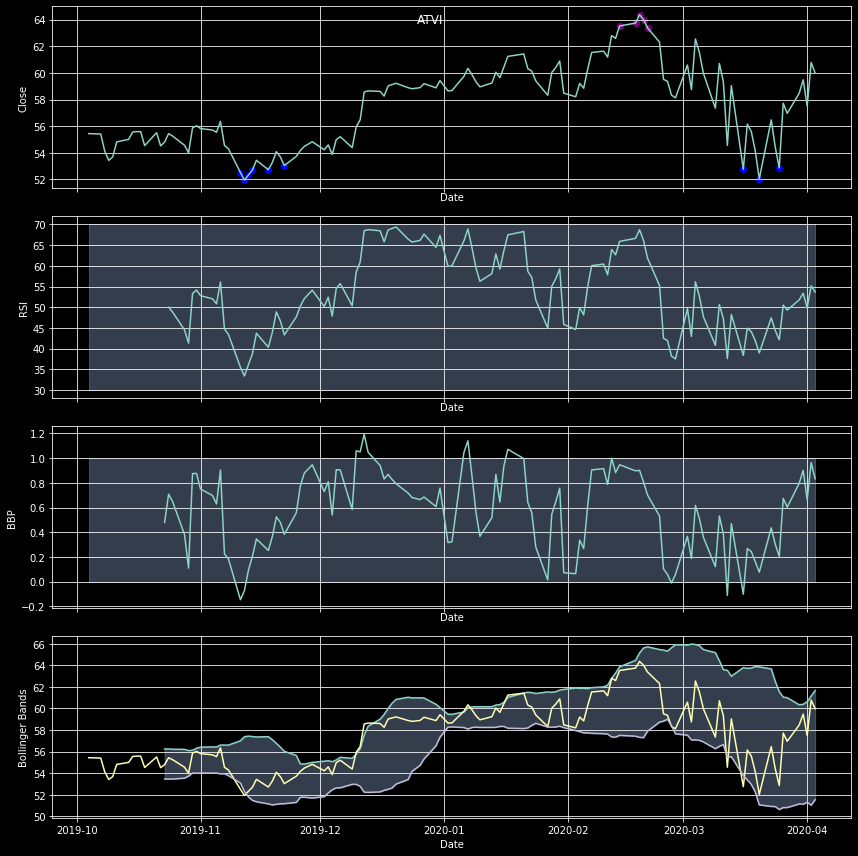

Date
2019-10-23   -0.991905
2020-03-18    1.000000
Name: (ADS, BLOW_SHIGH), dtype: float64

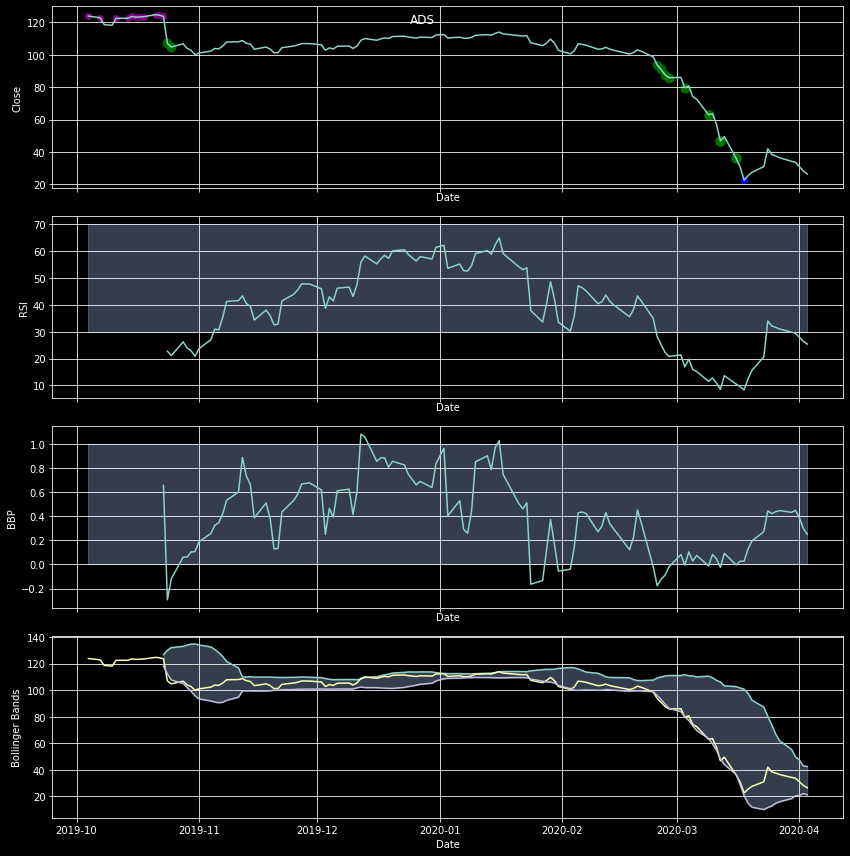

Date
2020-03-20    0.985359
2020-03-23    1.000000
Name: (GOOG, BLOW_SHIGH), dtype: float64

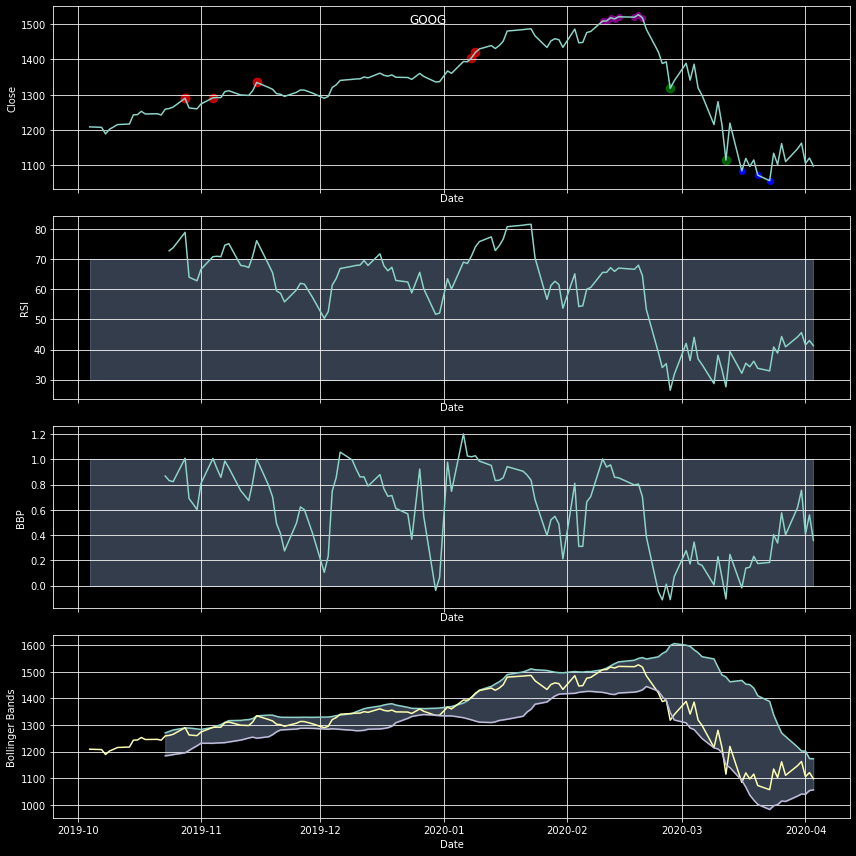

Date
2020-03-20    0.985948
2020-03-23    0.995882
Name: (MSFT, BLOW_SHIGH), dtype: float64

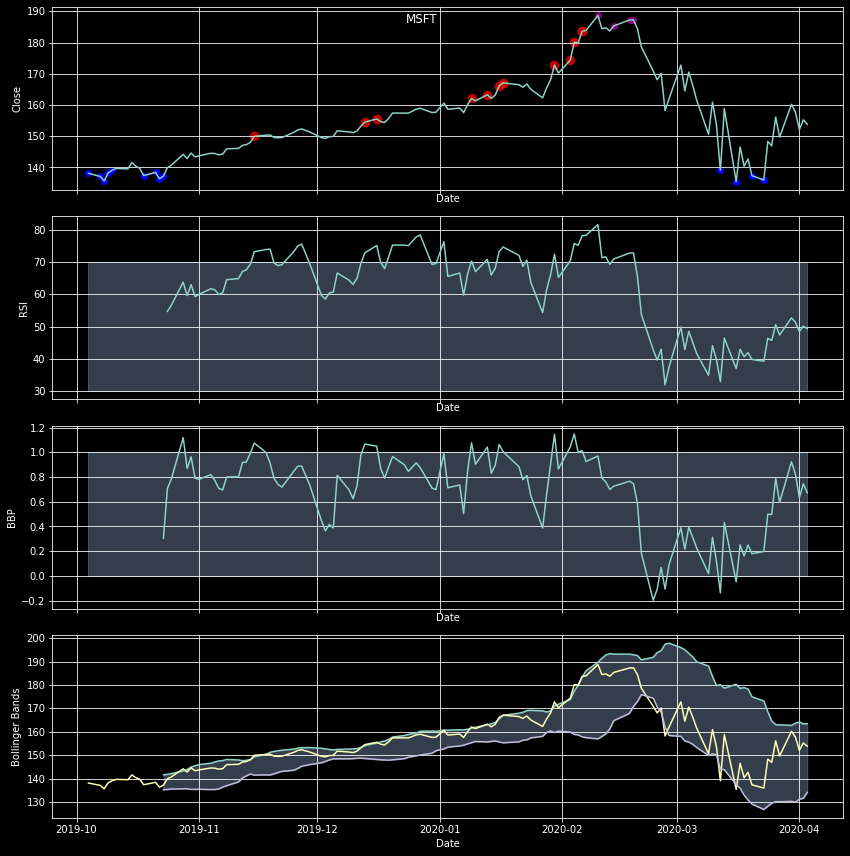

Date
2020-03-12    1.000000
2020-03-16    0.992576
Name: (AMZN, BLOW_SHIGH), dtype: float64

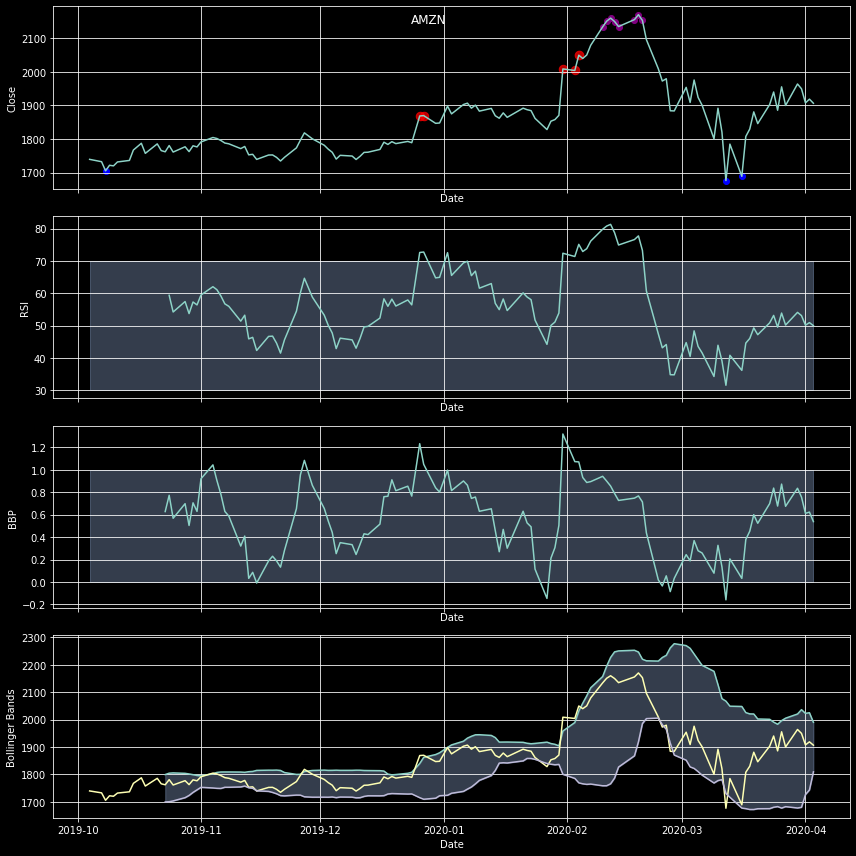

Date
2019-10-25   -0.9801
2020-03-16    1.0000
Name: (TEF, BLOW_SHIGH), dtype: float64

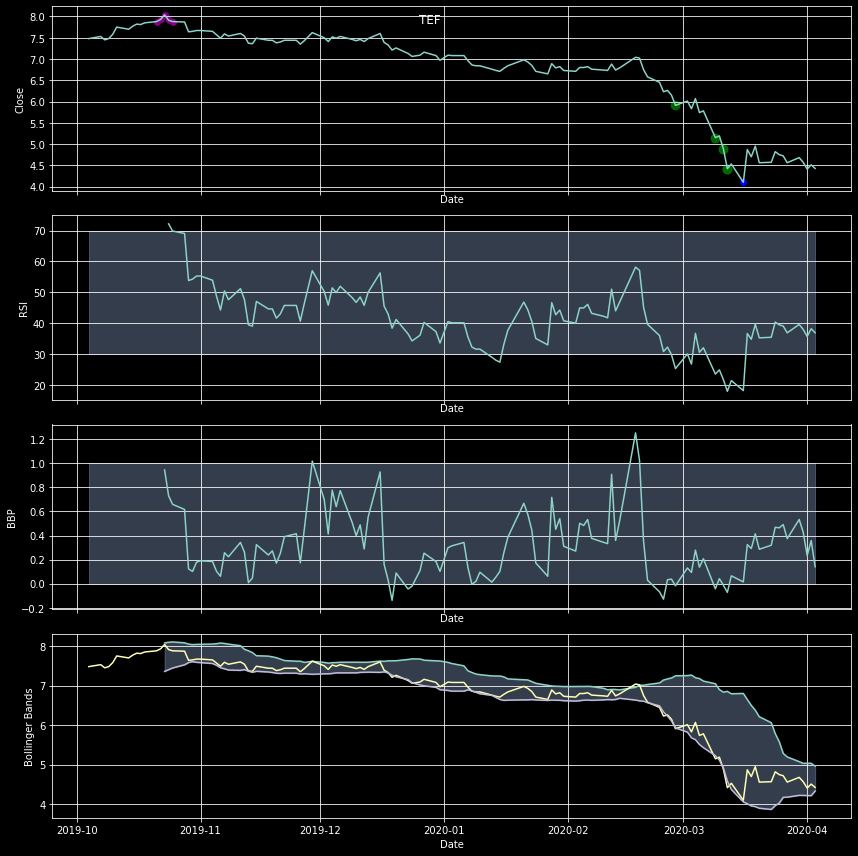

Date
2020-03-23    0.968750
2020-03-24    0.939394
Name: (CHFS, BLOW_SHIGH), dtype: float64

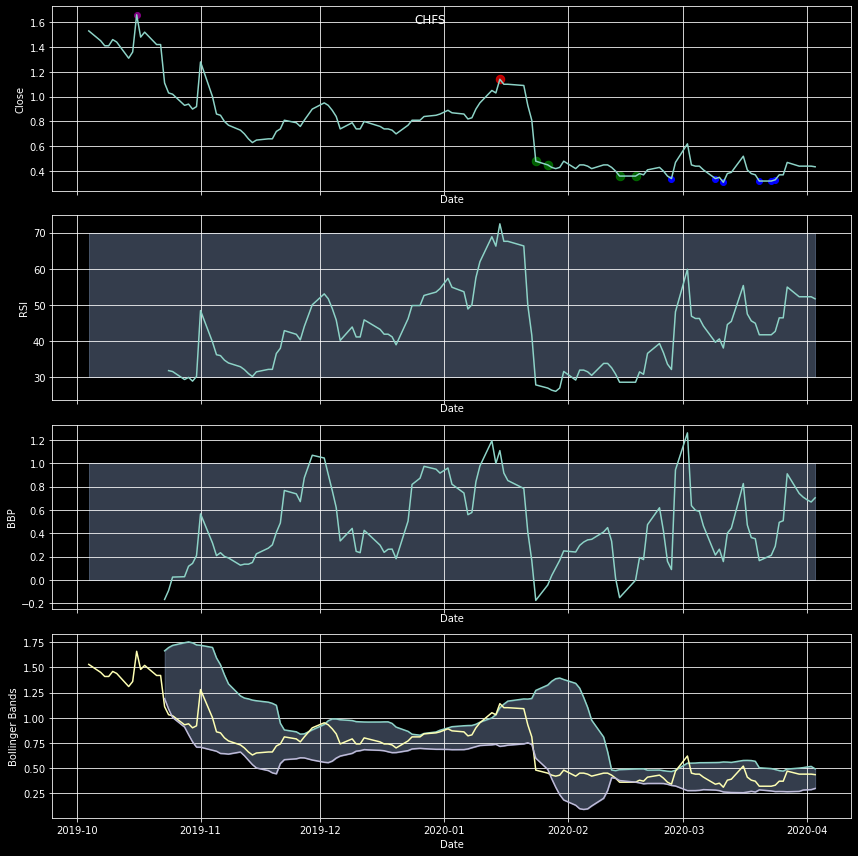

Date
2020-03-24    0.973214
2020-03-25   -1.000000
Name: (ASTC, BLOW_SHIGH), dtype: float64

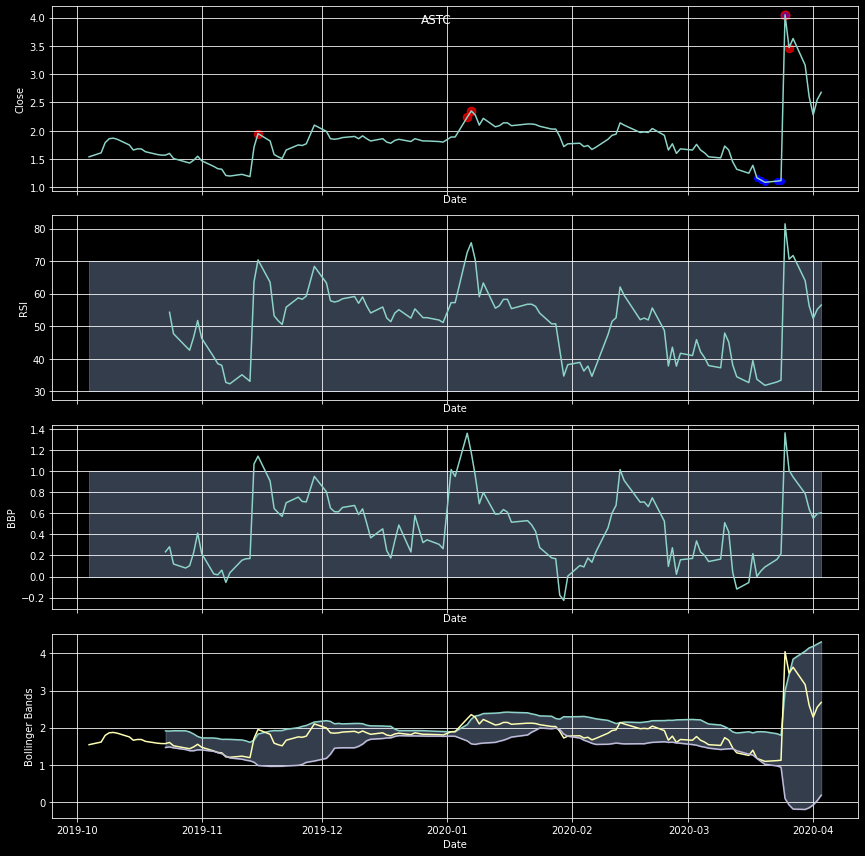

Date
2020-02-21   -0.986673
2020-03-18    1.000000
Name: (UBER, BLOW_SHIGH), dtype: float64

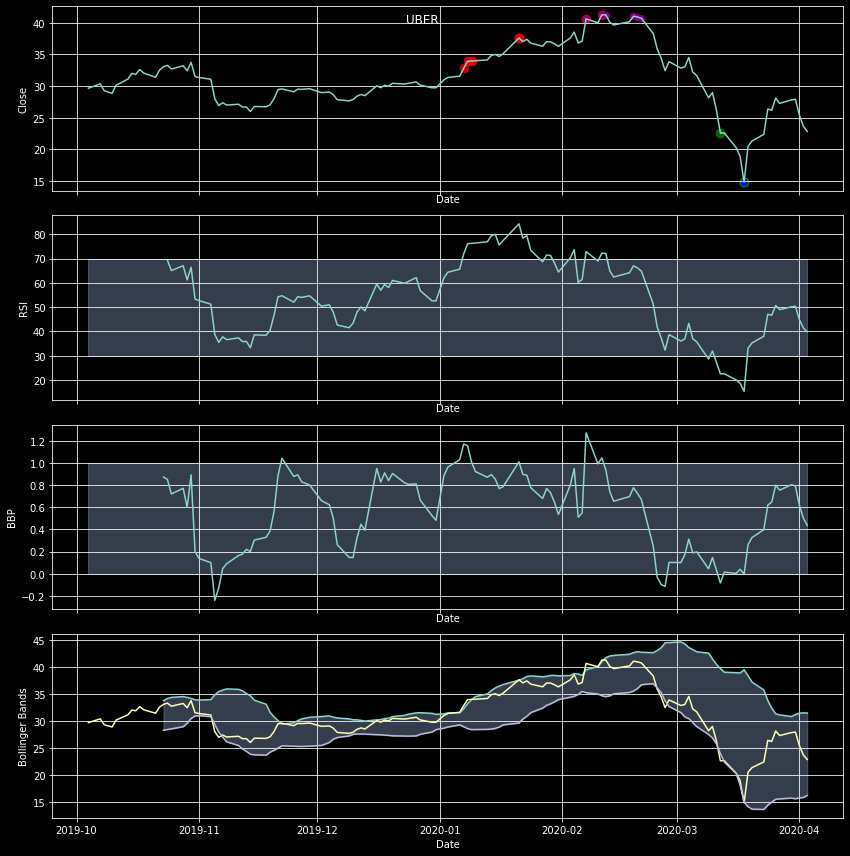

In [154]:
"""Display results"""
for tick in tickers_desc.keys():
    bl = hist[tick, 'BLOW_SHIGH']
    display(bl[bl != 0].tail(2))
    plot_result(df=hist, ticker=tick)

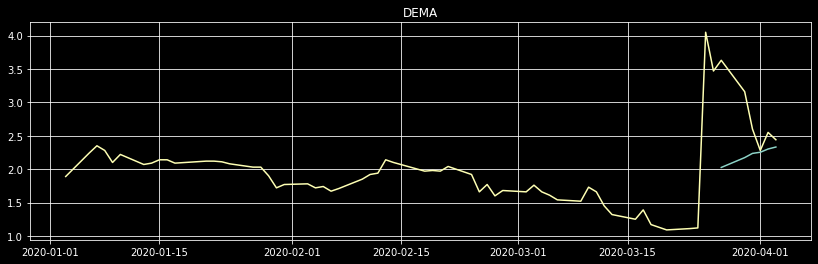

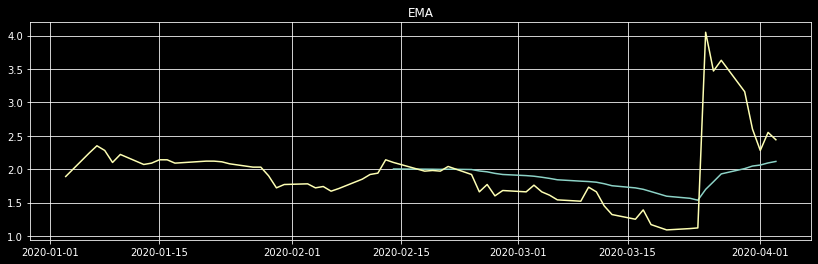

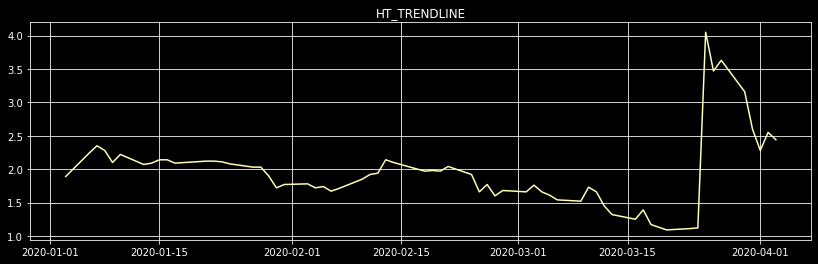

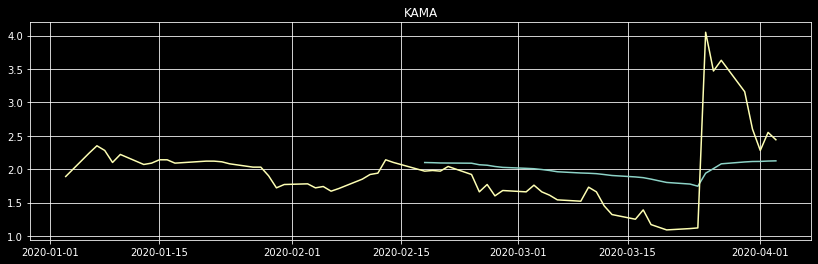

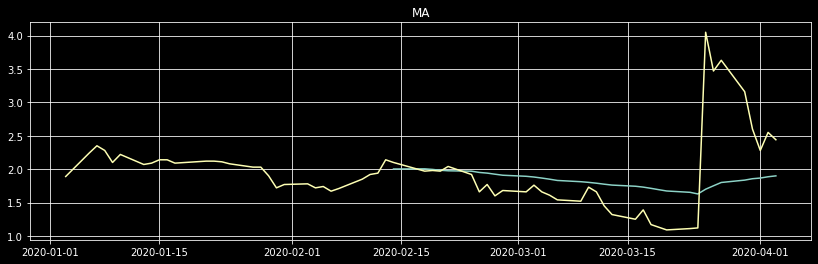

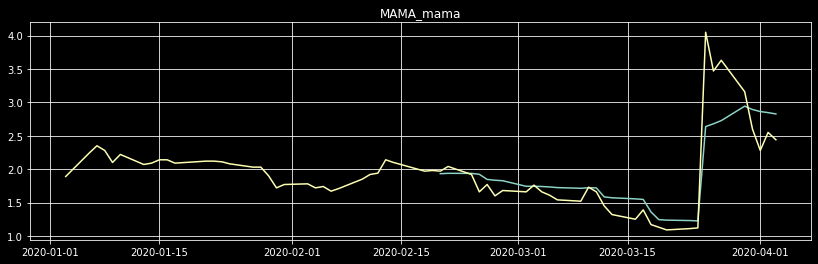

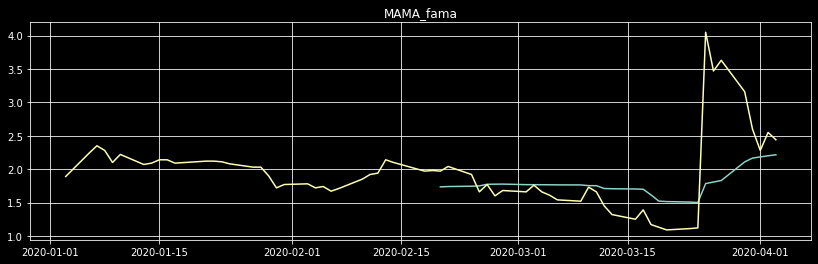

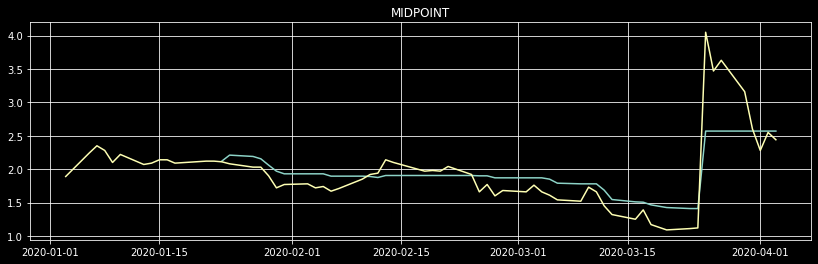

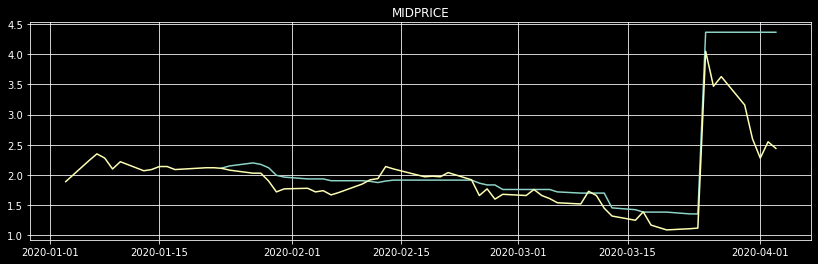

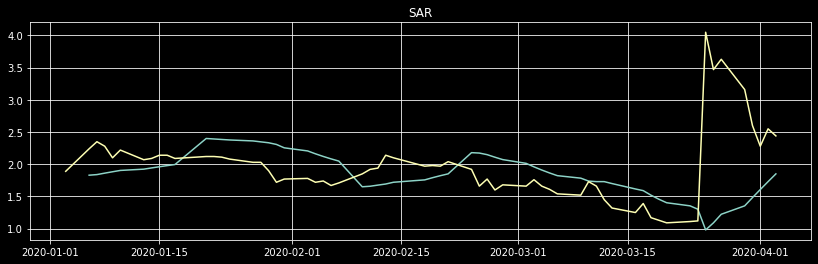

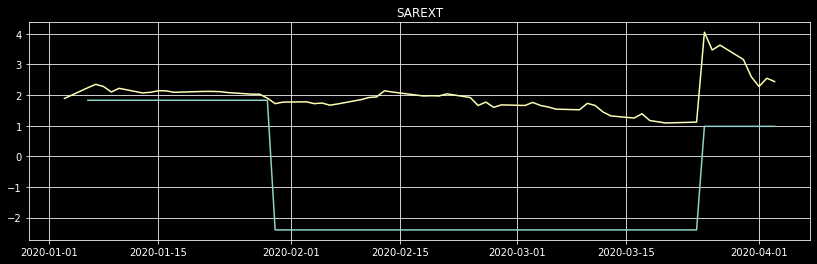

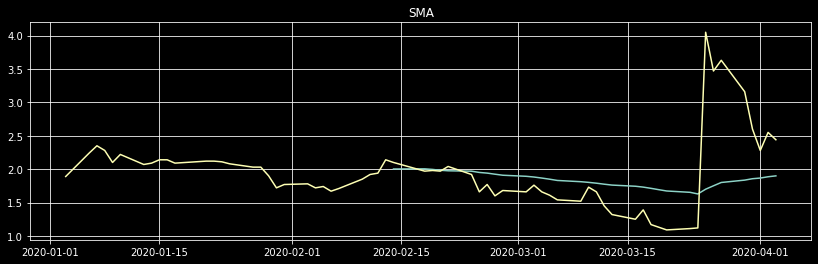

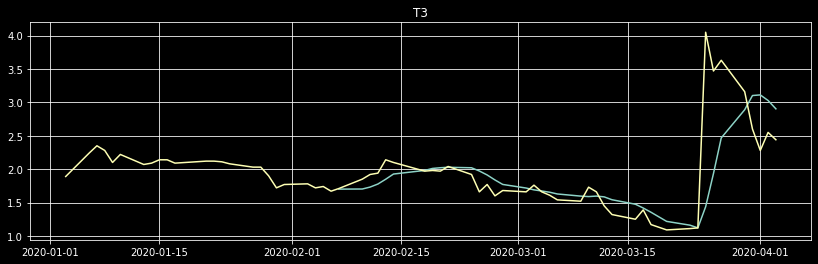

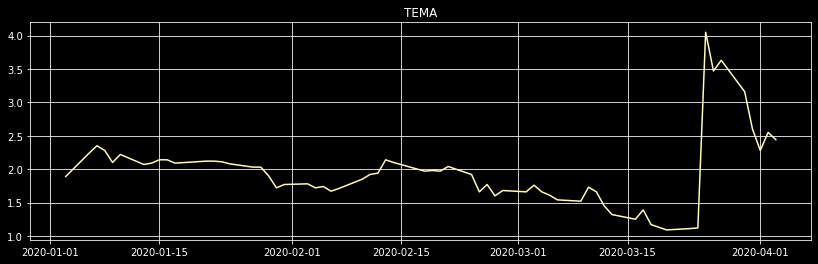

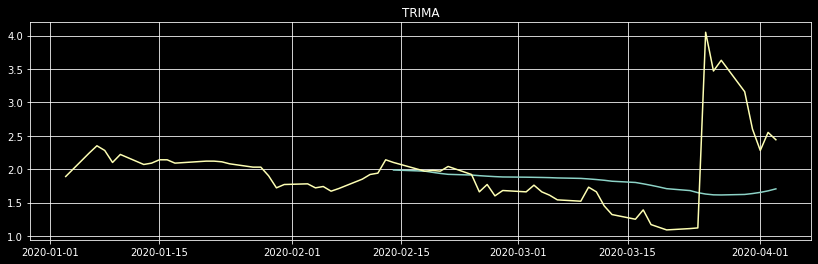

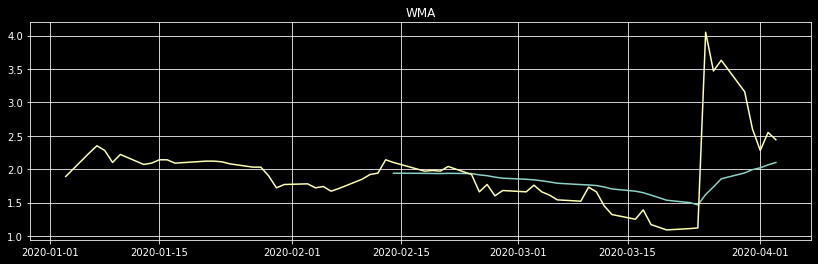

In [60]:
# Show overlap functions
overlap_functions = ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_mama', 'MAMA_fama', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA']
for func in overlap_functions:
    plt.figure(figsize=(14,4))
    plt.title(func)
    plt.grid()
    plt.plot(hist['ASTC', func])
    plt.plot(hist['ASTC', 'Close'])
    # Show/save figure as desired.
    plt.show()

In [0]:
from talib import CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARAMICROSS, CDLHIGHWAVE, CDLHIKKAKE, CDLHIKKAKEMOD, CDLHOMINGPIGEON, CDLIDENTICAL3CROWS, CDLINNECK, CDLINVERTEDHAMMER, CDLKICKING, CDLKICKINGBYLENGTH, CDLLADDERBOTTOM, CDLLONGLEGGEDDOJI, CDLLONGLINE, CDLMARUBOZU, CDLMATCHINGLOW, CDLMATHOLD, CDLMORNINGDOJISTAR, CDLMORNINGSTAR, CDLONNECK, CDLPIERCING, CDLRICKSHAWMAN, CDLRISEFALL3METHODS, CDLSEPARATINGLINES, CDLSHOOTINGSTAR, CDLSHORTLINE, CDLSPINNINGTOP, CDLSTALLEDPATTERN, CDLSTICKSANDWICH, CDLTAKURI, CDLTASUKIGAP, CDLTHRUSTING, CDLTRISTAR, CDLUNIQUE3RIVER, CDLUPSIDEGAP2CROWS, CDLXSIDEGAP3METHODS

patterns = [CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARAMICROSS, CDLHIGHWAVE, CDLHIKKAKE, CDLHIKKAKEMOD, CDLHOMINGPIGEON, CDLIDENTICAL3CROWS, CDLINNECK, CDLINVERTEDHAMMER, CDLKICKING, CDLKICKINGBYLENGTH, CDLLADDERBOTTOM, CDLLONGLEGGEDDOJI, CDLLONGLINE, CDLMARUBOZU, CDLMATCHINGLOW, CDLMATHOLD, CDLMORNINGDOJISTAR, CDLMORNINGSTAR, CDLONNECK, CDLPIERCING, CDLRICKSHAWMAN, CDLRISEFALL3METHODS, CDLSEPARATINGLINES, CDLSHOOTINGSTAR, CDLSHORTLINE, CDLSPINNINGTOP, CDLSTALLEDPATTERN, CDLSTICKSANDWICH, CDLTAKURI, CDLTASUKIGAP, CDLTHRUSTING, CDLTRISTAR, CDLUNIQUE3RIVER, CDLUPSIDEGAP2CROWS, CDLXSIDEGAP3METHODS]
patterns_names = ['CDL2CROWS - Two Crows', 'CDL3BLACKCROWS - Three Black Crows', 'CDL3INSIDE - Three Inside Up/Down', 'CDL3LINESTRIKE - Three-Line Strike', 'CDL3OUTSIDE - Three Outside Up/Down', 'CDL3STARSINSOUTH - Three Stars In The South', 'CDL3WHITESOLDIERS - Three Advancing White Soldiers', 'CDLABANDONEDBABY - Abandoned Baby', 'CDLADVANCEBLOCK - Advance Block', 'CDLBELTHOLD - Belt-hold', 'CDLBREAKAWAY - Breakaway', 'CDLCLOSINGMARUBOZU - Closing Marubozu', 'CDLCONCEALBABYSWALL - Concealing Baby Swallow', 'CDLCOUNTERATTACK - Counterattack', 'CDLDARKCLOUDCOVER - Dark Cloud Cover', 'CDLDOJI - Doji', 'CDLDOJISTAR - Doji Star', 'CDLDRAGONFLYDOJI - Dragonfly Doji', 'CDLENGULFING - Engulfing Pattern', 'CDLEVENINGDOJISTAR - Evening Doji Star', 'CDLEVENINGSTAR - Evening Star', 'CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines', 'CDLGRAVESTONEDOJI - Gravestone Doji', 'CDLHAMMER - Hammer', 'CDLHANGINGMAN - Hanging Man', 'CDLHARAMI - Harami Pattern', 'CDLHARAMICROSS - Harami Cross Pattern', 'CDLHIGHWAVE - High-Wave Candle', 'CDLHIKKAKE - Hikkake Pattern', 'CDLHIKKAKEMOD - Modified Hikkake Pattern', 'CDLHOMINGPIGEON - Homing Pigeon', 'CDLIDENTICAL3CROWS - Identical Three Crows', 'CDLINNECK - In-Neck Pattern', 'CDLINVERTEDHAMMER - Inverted Hammer', 'CDLKICKING - Kicking', 'CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu', 'CDLLADDERBOTTOM - Ladder Bottom', 'CDLLONGLEGGEDDOJI - Long Legged Doji', 'CDLLONGLINE - Long Line Candle', 'CDLMARUBOZU - Marubozu', 'CDLMATCHINGLOW - Matching Low', 'CDLMATHOLD - Mat Hold', 'CDLMORNINGDOJISTAR - Morning Doji Star', 'CDLMORNINGSTAR - Morning Star', 'CDLONNECK - On-Neck Pattern', 'CDLPIERCING - Piercing Pattern', 'CDLRICKSHAWMAN - Rickshaw Man', 'CDLRISEFALL3METHODS - Rising/Falling Three Methods', 'CDLSEPARATINGLINES - Separating Lines', 'CDLSHOOTINGSTAR - Shooting Star', 'CDLSHORTLINE - Short Line Candle', 'CDLSPINNINGTOP - Spinning Top', 'CDLSTALLEDPATTERN - Stalled Pattern', 'CDLSTICKSANDWICH - Stick Sandwich', 'CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)', 'CDLTASUKIGAP - Tasuki Gap', 'CDLTHRUSTING - Thrusting Pattern', 'CDLTRISTAR - Tristar Pattern', 'CDLUNIQUE3RIVER - Unique 3 River', 'CDLUPSIDEGAP2CROWS - Upside Gap Two Crows', 'CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Method']

for patt, patt_name in zip(patterns, patterns_names):
    integer = patt(hist['Open', stock_symbol], 
                    hist['High', stock_symbol], 
                    hist['Low', stock_symbol], 
                    hist['Close', stock_symbol])
    if len(integer.tail(2).unique()) > 1:
        print(patt_name)
        print(integer.tail(2))

CDLSHORTLINE - Short Line Candle
Date
2020-03-30      0
2020-03-31   -100
dtype: int32
CDLSPINNINGTOP - Spinning Top
Date
2020-03-30      0
2020-03-31   -100
dtype: int32


In [0]:
import talib

print(talib.get_functions())

for key,value in talib.get_function_groups().items():
  print(key,value)

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',